In [22]:
# this program will code a circuit described below:  
# https://www.nature.com/articles/s41586-023-06096-3
# credit to Derek Wang
# https://www.youtube.com/watch?v=35ykEg3fG4c&t=4s

# Tranverse field Ising model to demonstrate primitives

In [ ]:
# s dagger: conjugate transpose of s gate
# ((1,0), (0,-i))
# s gate: also z90 because it represents 90 degree rotation around z axis
# ((1,0), (0,i))
# s dagger is applied to all qubits 
# big picture point of the program is to send qubits through circuit twice,
# measure the end, see if it was messed up 
# "survival probability of all 0 bit string"
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

# define custom gates not available in qiskit library 
SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}$")

# generate 1d transerve field ising model circuit
def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    
    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # adding Rzz in even layers (0 is start, qc.num_qubits - 1 is end, 2 is step)
    for i in range(0, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])  # s dagger 
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
        
    # adding Rzz in odd layers 
    for i in range(1, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])  # s dagger 
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
        
    # adding Rx to all qubits 
    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
        

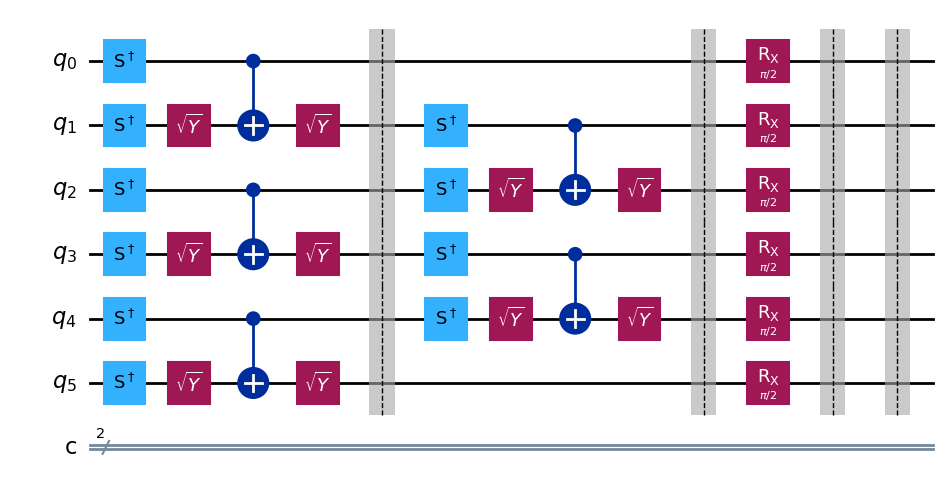

In [28]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi # rx_angle = pi/2

# make quantum circuit 
qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, 2, trotter_barriers=True, layer_barriers=True)
qc.draw('mpl', fold=-1) # fold=-1 puts it all on one line if really big

# Sampler Demo

In [ ]:
# make inverse circuits
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):
    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
        

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # adding negative Rx to all qubits 
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    
    # adding Rzz in odd layers 
    for i in range(1, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    
    if layer_barriers:
        qc.barrier()
    
    # adding Rzz in even layers 
    for i in range(0, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    
    if layer_barriers:
        qc.barrier() 
    

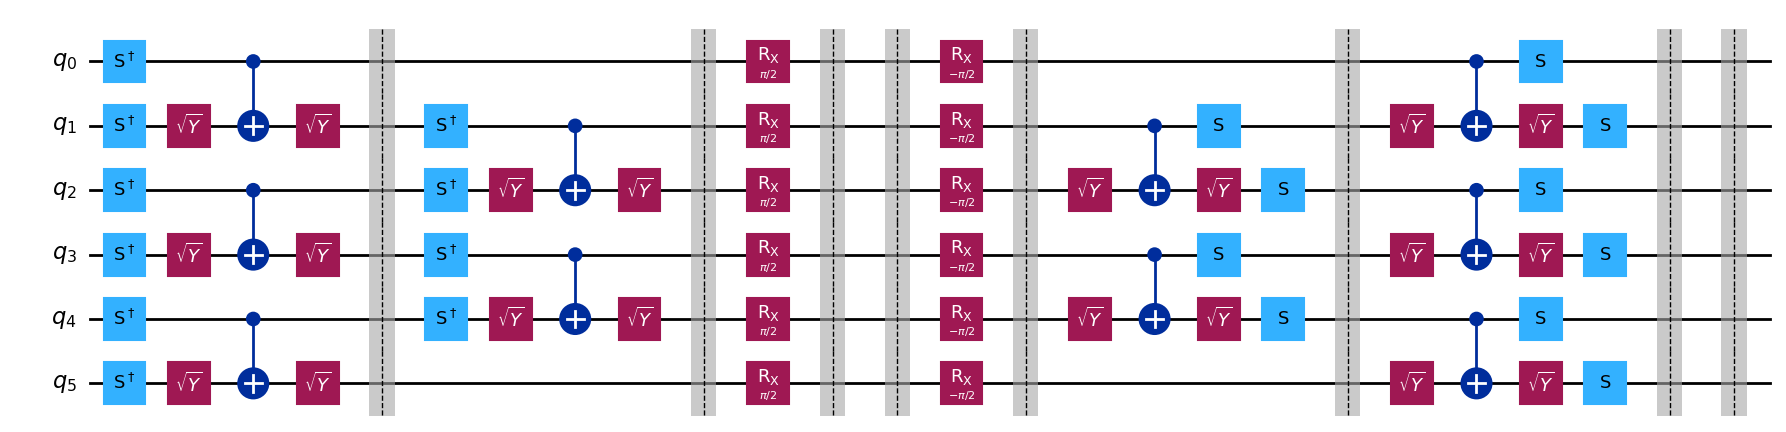

In [ ]:
append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw('mpl', fold=-1) # fold=-1 puts it all on one line if
# on the left is the original direction, the right is the inverse direction
# we can expect the output will be the same as the input, because everything should be undone
# this circuit is a way to observe the amount of noise as we increase the depth of the circuit

# Step 1: Map problem to circuits and observables 

In [40]:
max_trotter_steps = 10  # max number of trotter steps
num_qubits = 100  # number of qubits on the QC
measured_qubits = [49, 50]  # the qubits we're measuring

qc_list = []  # list to store the quantum circuits
for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, trotter_step, rx_angle, num_cl_bits=len(
        measured_qubits), trotter_barriers=True, layer_barriers=True)
    append_mirrored_1d_tfim_circuit(
        qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

# qc_list[0].draw('mpl', fold=-1)

# Step 2: Optimize

In [ ]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"  # make string with backend name
# service = QiskitRuntimeService()
# backend = service.get_backend(backend_name)
# make instance of the backend service
backend = QiskitRuntimeService().backend(backend_name)
print("done getting backend")

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)
# print(qc_transpiled_list)
# qc_transpiled_list[0].draw('mpl', fold=-1)  # debug draw 1st circuit 

done getting backend


# Step 3: Execute on hardware

In [51]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# set up job
sampler = Sampler(backend) 
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

# get job id 
job = sampler.run(qc_transpiled_list)
print(job.job_id())

cz9td854spc00086sv60


# Step 4: Post-processing and plotting

In [56]:
# post processing 
job_id = 'cz9td854spc00086sv60'
job = service.job(job_id)

# survival probability of all 0 bit string?
survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots)
    except:
        survival_probability_list.append(0)


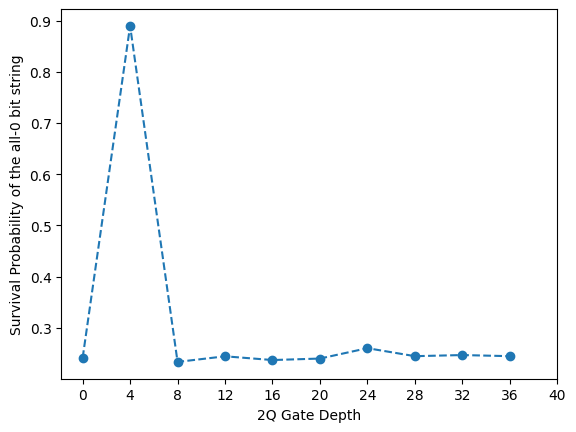

In [ ]:
# plotting
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel('2Q Gate Depth')
plt.ylabel('Survival Probability of the all-0 bit string')
plt.xticks(np.arange(0, 44, 4))
plt.show()

